In [1]:
import __init__

from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures,\
                            get_guided_encoder_output,\
                            ESM2_IF_repr
                            
import pandas as pd
import numpy as np
    
path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
complete_meltome_db = '../datasets/FLIP/splits/meltome/full_dataset_sequences.fasta'

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
train, val, test = train_test_validation_splits(splits_meltome)
train = seek_UniprotID_association_Meltome_prots(train, full_meltome_db)
test = seek_UniprotID_association_Meltome_prots(test, full_meltome_db)
val = seek_UniprotID_association_Meltome_prots(val, full_meltome_db)
#print(train)
print("Done")



#ff=full_meltome_db[full_meltome_db['sequence'].isin(train['sequence'])]

Done


In [3]:
import torch
import src.IF_PiFold_embeddings  as PiFoldconf 
#from src.IF_PiFold_embeddings import PiFold_setup


args = PiFoldconf.get_parser()
exp = PiFoldconf.PiFold_setup(args)
svpath = '../ref_models/PiFold/results/'
exp.method.load_state_dict(torch.load(svpath+'checkpoint.pth'))

Use GPU: cuda:0

device: 	cuda	
display_step: 	10	
res_dir: 	results	
ex_name: 	ProDesign	
use_gpu: 	True	
gpu: 	0	
seed: 	111	
data_name: 	CATH	
data_root: 	data/	
batch_size: 	8	
num_workers: 	8	
method: 	ProDesign	
config_file: 	None	
hidden_dim: 	128	
node_features: 	128	
edge_features: 	128	
k_neighbors: 	30	
dropout: 	0.1	
num_encoder_layers: 	10	
epoch: 	100	
log_step: 	1	
lr: 	0.001	
patience: 	100	
updating_edges: 	4	
node_dist: 	1	
node_angle: 	1	
node_direct: 	1	
edge_dist: 	1	
edge_angle: 	1	
edge_direct: 	1	
virtual_num: 	3	


<All keys matched successfully>

In [4]:
from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.ESM2_IF1_embeddings import ESM2_IF1_embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer

structuredir = '../datasets/Structures/'
meltome_struct_dir_labels = '../datasets/'


import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')



Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t')
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t')
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t')


train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')



In [5]:

import torch, os, gc
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import warnings
warnings.filterwarnings('ignore')


"""import esm
model, alphabet = esm.pretrained.load_model_and_alphabet_local("../models/esm_if1_gvp4_t16_142M_UR50.pt")#esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()"""

#IF1 = ESM2_IF1_embeddings()


pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2_with_StructAssociation.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2_with_StructAssociation.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2_with_StructAssociation.pth'

path_IFtrain= dir_pre_generated_embeddings+'train_set_IFPiFoldembeddings_ESM2_StructAssociation.pth'
path_IFtest= dir_pre_generated_embeddings+'test_set_IFPiFoldembeddings_ESM2_StructAssociation.pth'
path_IFval= dir_pre_generated_embeddings+'val_set_IFPiFoldembeddings_ESM2_StructAssociation.pth'




def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:
        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings


#def IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval):
def IFBuilder_sets(IF, train, test, val, path_IFtrain, path_IFtest, path_IFval):

    if os.path.isfile(path_IFtrain)==False and os.path.isfile(path_IFtest)==False and os.path.isfile(path_IFval)==False:

        #IF_embeddings_train = ESM2_IF_repr(train, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_train')
        IF_embeddings_train = IF.IF_repr(train, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_train')
        torch.save(IF_embeddings_train, path_IFtrain)

        #IF_embeddings_test = ESM2_IF_repr(test, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_test')
        IF_embeddings_test = IF.IF_repr(test, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_test')
        torch.save(IF_embeddings_test, path_IFtest)

        #IF_embeddings_val = ESM2_IF_repr(val, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_val')
        IF_embeddings_val = IF.IF_repr(val, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_val')
        torch.save(IF_embeddings_val, path_IFval)
    else:
        print ("Loading Premade Embeddings...")
        IF_embeddings_train = torch.load(path_IFtrain)
        IF_embeddings_test = torch.load(path_IFtest)
        IF_embeddings_val = torch.load(path_IFval)
        print ("Loaded")
    return IF_embeddings_train, IF_embeddings_test, IF_embeddings_val



In [6]:
#train_IF_embedding, test_IF_embedding, val_IF_embedding = IFBuilder_sets(IF1, train, test, val, path_IFtrain, path_IFtest, path_IFval)
train_embeddings, test_embeddings, val_embeddings = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)
train_IF_embedding, test_IF_embedding, val_IF_embedding = IFBuilder_sets(exp, train, test, val, path_IFtrain, path_IFtest, path_IFval)

train_loaderESM2 = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderESM2 = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderESM2 = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)


train_loaderIF = tensor2dataloader(train_IF_embedding, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderIF = tensor2dataloader(test_IF_embedding, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderIF = tensor2dataloader(val_IF_embedding, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

"""
train_loaderMixed = tensor2dataloader(torch.concat([train_embeddings.to(device), train_IF_embedding.to(device)],dim=1), torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderMixed = tensor2dataloader(torch.concat([test_embeddings.to(device), test_IF_embedding.to(device)],dim=1), torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderMixed = tensor2dataloader(torch.concat([val_embeddings.to(device), val_IF_embedding.to(device)],dim=1), torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)
"""

Loading Premade Embeddings...
Loaded
Loading Premade Embeddings...
Loaded


In [7]:
def generating_results_approaches(FFNNreg, Trner, train_loader, val_loader, test_loader,loss, opt, epochs, device):
    FFNNreg, val_loss = Trner.train_LLMRegresor(train_loader, val_loader, FFNNreg, device, loss, opt, epochs)

    test_set, test_labels = test_loader.dataset.tensors
    loss_test, outcome = Trner.test_model(FFNNreg, test_set, test_labels, loss, device)

    from src.utilities import plot_results

    plot_results( outcome, test_labels)

### For RAW ESM2

epoch: 1 loss: 21.789 val loss: 113.446
epoch: 2 loss: 5.611 val loss: 111.828
epoch: 3 loss: 47.496 val loss: 56.717
epoch: 4 loss: 648.598 val loss: 45.024
epoch: 5 loss: 23.610 val loss: 40.097
epoch: 6 loss: 36.628 val loss: 38.095
epoch: 7 loss: 7.417 val loss: 37.650
epoch: 8 loss: 21.683 val loss: 36.838
epoch: 9 loss: 0.932 val loss: 37.435
epoch: 10 loss: 85.451 val loss: 36.817
epoch: 11 loss: 2.300 val loss: 36.780
epoch: 12 loss: 0.000 val loss: 36.339
epoch: 13 loss: 157.872 val loss: 36.059
epoch: 14 loss: 112.966 val loss: 35.917
epoch: 15 loss: 38.804 val loss: 35.355
epoch: 16 loss: 0.050 val loss: 34.350
epoch: 17 loss: 15.183 val loss: 35.352
epoch: 18 loss: 60.357 val loss: 35.534
epoch: 19 loss: 166.733 val loss: 34.271
epoch: 20 loss: 12.812 val loss: 34.328
epoch: 21 loss: 0.327 val loss: 33.271
epoch: 22 loss: 41.064 val loss: 33.055
epoch: 23 loss: 2.501 val loss: 33.661
epoch: 24 loss: 0.421 val loss: 32.857
epoch: 25 loss: 5.281 val loss: 32.751
MSE: tensor(3

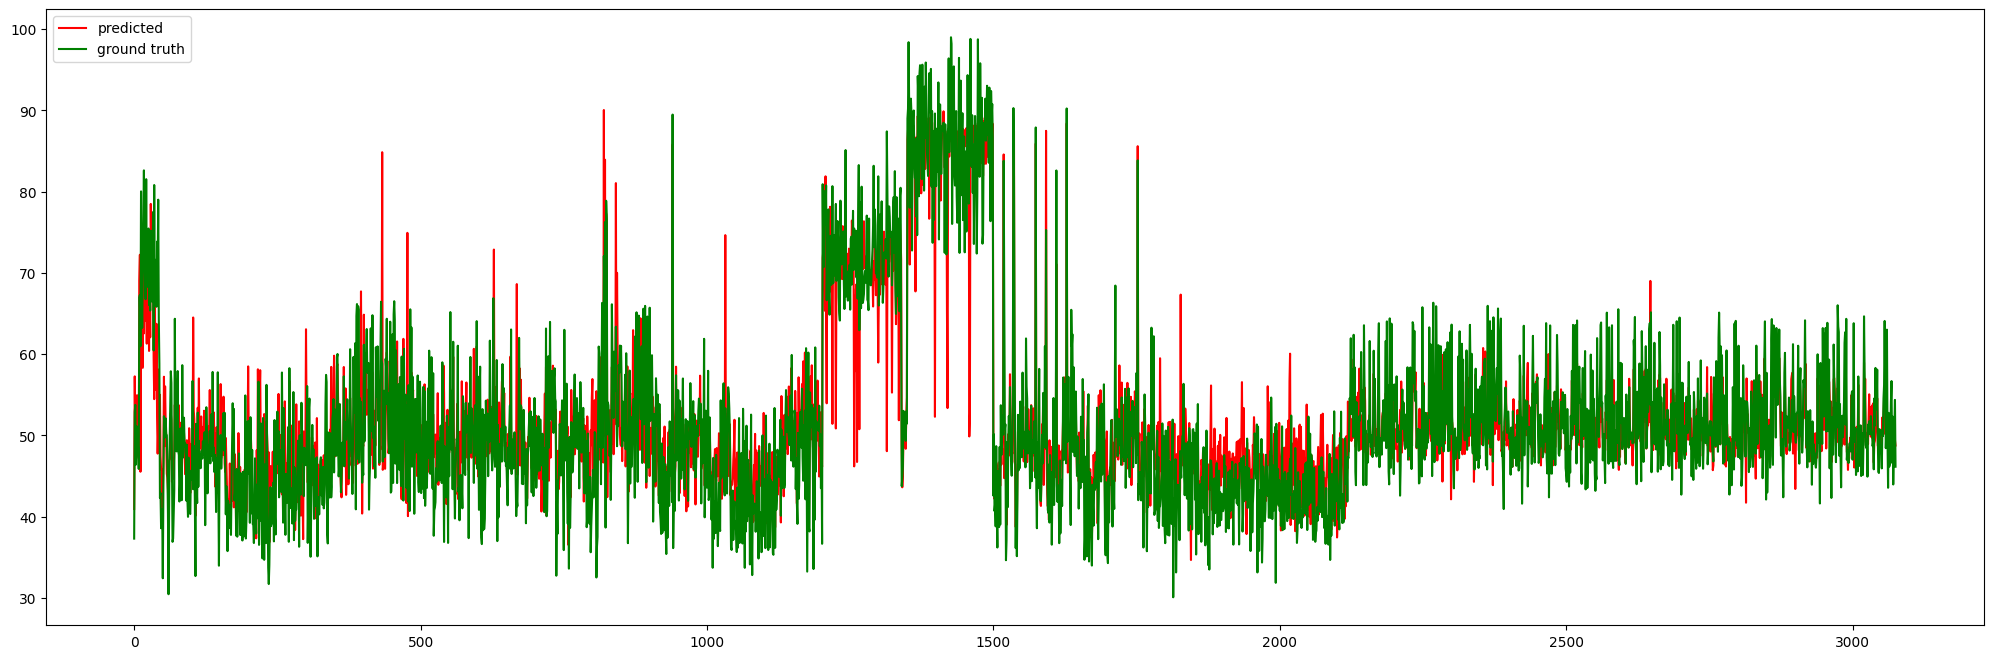

In [14]:
Trainer1 = Trainer()
FFNN_ESM2 = regressionHead(train_embeddings.shape[1::])
optESM2 = torch.optim.Adam(FFNN_ESM2.parameters(), lr=1e-3)
lossESM2= torch.nn.MSELoss()
epochs = 25

generating_results_approaches(FFNN_ESM2, Trainer1, train_loaderESM2, val_loaderESM2, test_loaderESM2,lossESM2, optESM2, epochs, device)

### For Inverse Folding ESM2 Contribution

epoch: 1 loss: 107.560 val loss: 113.719
epoch: 2 loss: 243.765 val loss: 113.609
epoch: 3 loss: 20.864 val loss: 114.142
epoch: 4 loss: 144.543 val loss: 94.649
epoch: 5 loss: 3.224 val loss: 84.751
epoch: 6 loss: 6.653 val loss: 81.439
epoch: 7 loss: 21.682 val loss: 79.864
epoch: 8 loss: 187.510 val loss: 79.876
epoch: 9 loss: 28.982 val loss: 79.163
epoch: 10 loss: 22.889 val loss: 78.267
epoch: 11 loss: 4.240 val loss: 78.053
epoch: 12 loss: 1173.192 val loss: 84.014
epoch: 13 loss: 154.617 val loss: 77.635
epoch: 14 loss: 69.523 val loss: 77.927
epoch: 15 loss: 261.475 val loss: 77.369
epoch: 16 loss: 27.258 val loss: 76.502
epoch: 17 loss: 11.066 val loss: 76.991
epoch: 18 loss: 18.579 val loss: 76.556
epoch: 19 loss: 36.688 val loss: 76.265
epoch: 20 loss: 16.803 val loss: 75.779
epoch: 21 loss: 8.925 val loss: 78.986
epoch: 22 loss: 5.253 val loss: 77.674
epoch: 23 loss: 0.054 val loss: 76.449
epoch: 24 loss: 7.433 val loss: 77.064
epoch: 25 loss: 3.777 val loss: 74.876
epoch:

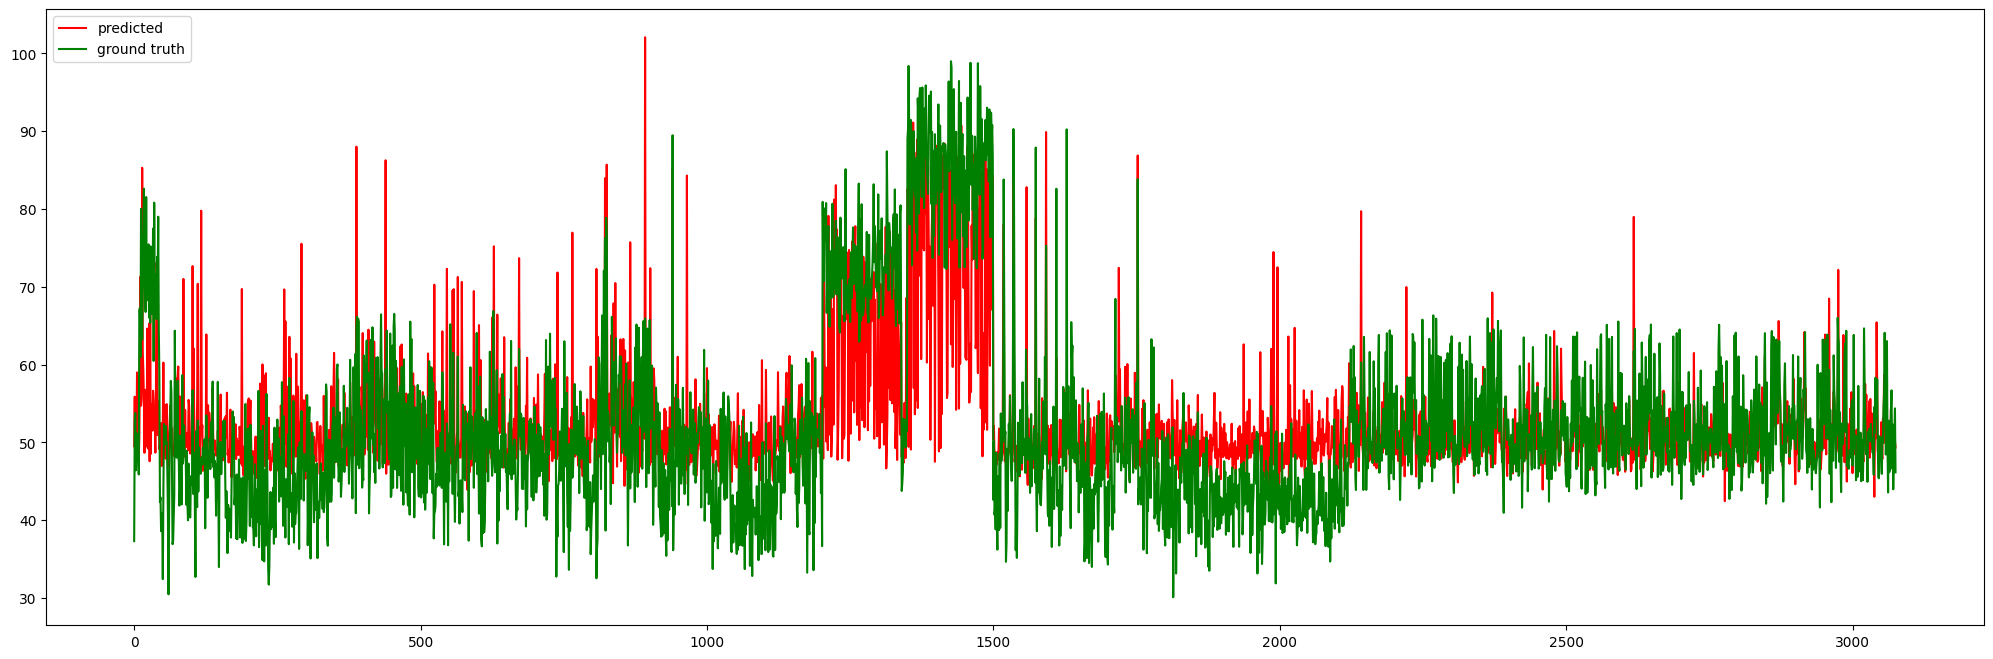

In [9]:
Trainer2 = Trainer()
FFNN_IF = regressionHead(train_IF_embedding.shape[1::] )
optIF = torch.optim.Adam(FFNN_IF.parameters(), lr=1e-3)
lossIF= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_IF, Trainer2, train_loaderIF, val_loaderIF, test_loaderIF,lossIF, optIF, epochs, device)

### Combining Raw ESM2 and Inverse Folding Embeddings

epoch: 1 loss: 2.139 val loss: 113.788
epoch: 2 loss: 1.059 val loss: 114.285
epoch: 3 loss: 2.813 val loss: 65.213
epoch: 4 loss: 23.087 val loss: 45.412
epoch: 5 loss: 67.908 val loss: 38.893
epoch: 6 loss: 4.088 val loss: 38.060
epoch: 7 loss: 0.623 val loss: 37.521
epoch: 8 loss: 0.213 val loss: 36.018
epoch: 9 loss: 35.723 val loss: 35.247
epoch: 10 loss: 4.400 val loss: 35.394
epoch: 11 loss: 11.888 val loss: 36.160
epoch: 12 loss: 0.219 val loss: 34.536
epoch: 13 loss: 190.922 val loss: 35.530
epoch: 14 loss: 7.919 val loss: 33.402
epoch: 15 loss: 0.456 val loss: 33.134
epoch: 16 loss: 71.884 val loss: 33.323
epoch: 17 loss: 23.719 val loss: 33.254
epoch: 18 loss: 0.187 val loss: 33.975
epoch: 19 loss: 73.638 val loss: 33.839
epoch: 20 loss: 106.538 val loss: 33.597
epoch: 21 loss: 4.770 val loss: 32.917
epoch: 22 loss: 218.275 val loss: 33.209
epoch: 23 loss: 94.298 val loss: 34.952
epoch: 24 loss: 9.914 val loss: 33.647
epoch: 25 loss: 35.098 val loss: 33.069
MSE: tensor(35.40

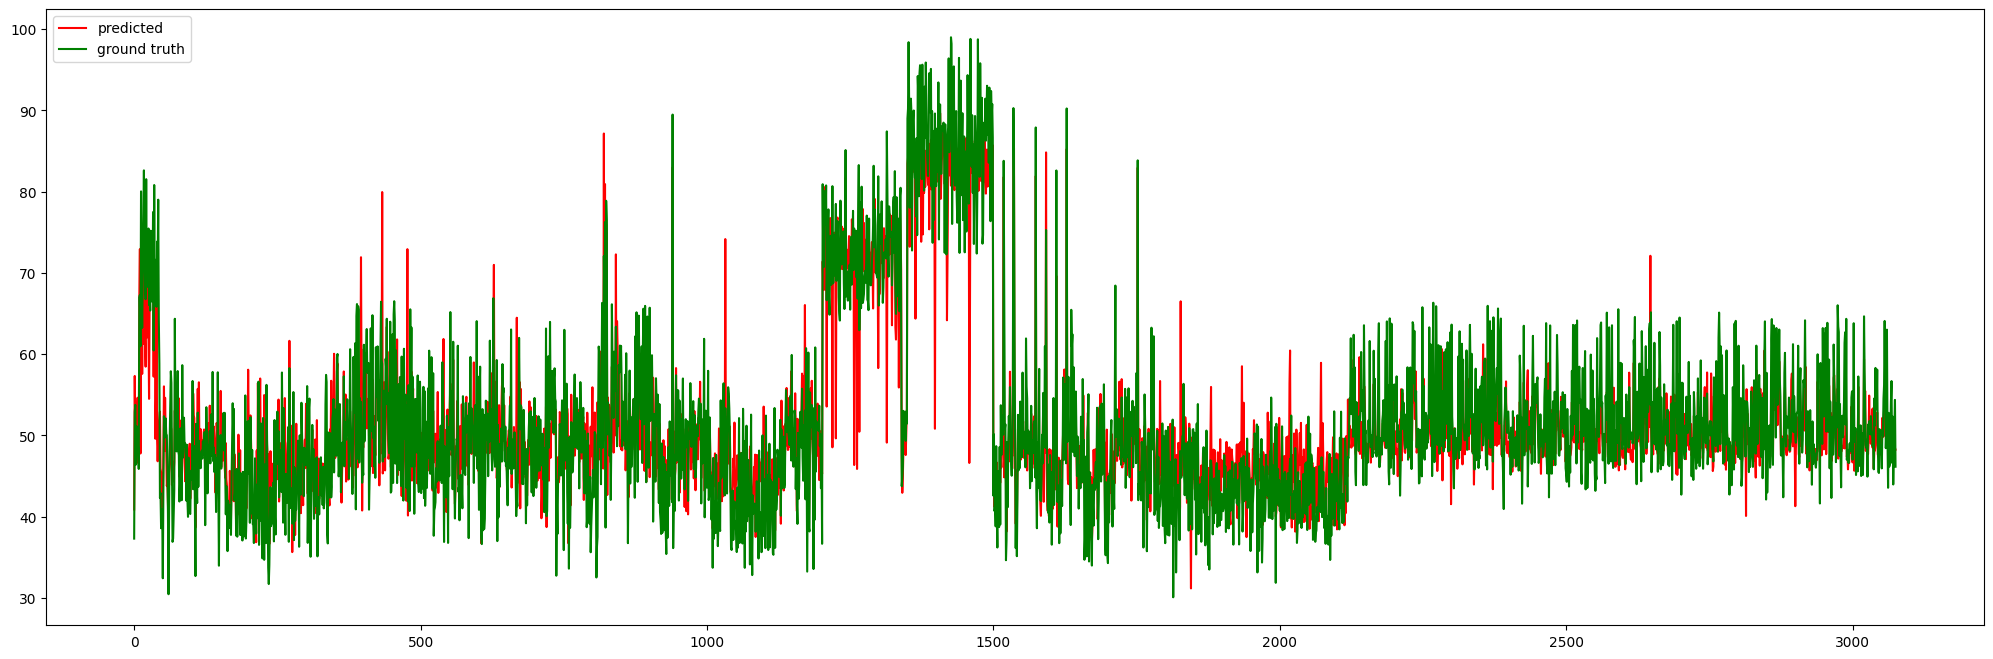

In [12]:
Trainer3 = Trainer()
FFNN_Mixed = regressionHead(train_IF_embedding.size(1) + train_embeddings.size(1))
optMixed = torch.optim.Adam(FFNN_Mixed.parameters(), lr=1e-3)
lossMixed= torch.nn.MSELoss()
epochs = 25

generating_results_approaches(FFNN_Mixed, Trainer3, train_loaderMixed, val_loaderMixed, test_loaderMixed,lossMixed, optMixed, epochs, device)